In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
if not os.path.exists('./TL_dataset'):
    patoolib.extract_archive('TL_dataset.zip')

In [ ]:
# Extracting the dataset and creating the train and test folders
data_dir = pathlib.Path('TL_dataset')
classes = os.listdir(data_dir)
print('classes: ',classes)

# Creating the train and validation folders
if not os.path.exists('./splited_dataset'):
    os.makedirs('./splited_dataset/train')
    os.makedirs('./splited_dataset/val')

    # Creating the class folders in train and validation folders
    for i in classes:
        os.makedirs('./splited_dataset/train/' + i)
        os.makedirs('./splited_dataset/val/' + i)

random.seed(0)
# Splitting the dataset into train and test sets
for i in classes:
    src = "./TL_dataset/" + i # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)*0.8)])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, "./splited_dataset/train/" + i)
    for name in val_FileNames:
        shutil.copy(name, "./splited_dataset/val/" + i)

classes:  ['1', '2', '3']
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9


In [ ]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}


In [ ]:
data_dir = 'splited_dataset'
sets = ['train','val']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=2)
                for x in ['train','val']}


In [ ]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['1', '2', '3']


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/24
----------
train Loss: 0.6166 Acc: 0.7381
val Loss: 0.2117 Acc: 0.9894

Epoch 1/24
----------
train Loss: 0.1947 Acc: 0.9365
val Loss: 0.0552 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0468 Acc: 1.0000
val Loss: 0.0271 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0245 Acc: 1.0000
val Loss: 0.0132 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0171 Acc: 1.0000
val Loss: 0.0077 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0145 Acc: 1.0000
val Loss: 0.0049 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0082 Acc: 1.0000
val Loss: 0.0037 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0073 Acc: 1.0000
val Loss: 0.0036 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0062 Acc: 1.0000
val Loss: 0.0035 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.0033 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0072 Acc: 1.0000
val Loss: 0.0032 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0063 Acc: 1.0000
val Loss: 0.0031 Acc: 1.0000

Ep

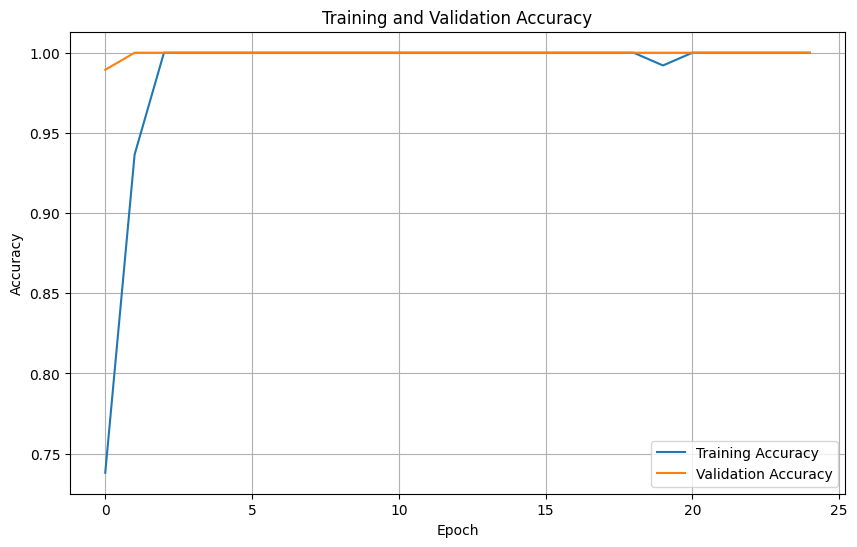

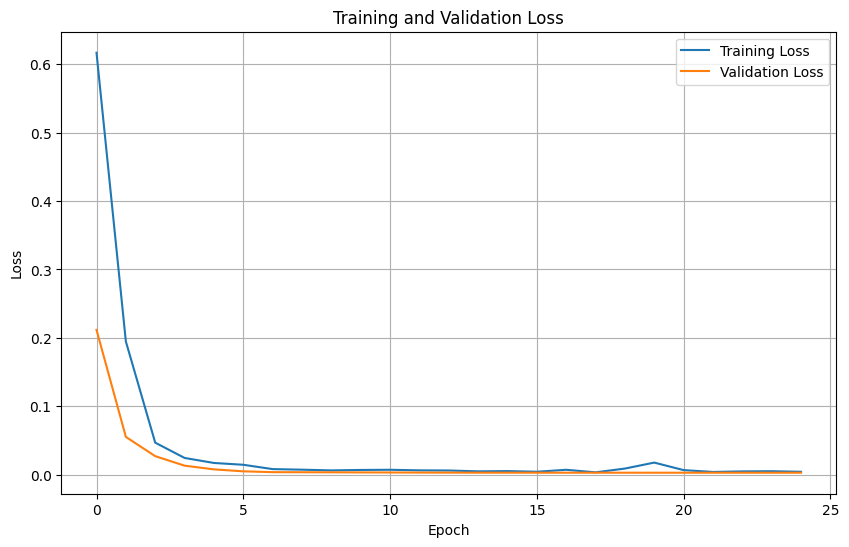

In [ ]:
pretrained_model = models.vgg16(pretrained=True)

# Exchange the last layer
num_ftrs = pretrained_model.classifier[6].in_features
pretrained_model.classifier[6] = nn.Linear(num_ftrs, 3)  # Modify the last layer to have 3 output classes
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001)

# Scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(pretrained_model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

torch.save(model.state_dict(), 'best_checkpoint.model')


Epoch 0/14
----------
train Loss: 0.7970 Acc: 0.6270
val Loss: 0.4698 Acc: 0.9149

Epoch 1/14
----------
train Loss: 0.4180 Acc: 0.8968
val Loss: 0.2684 Acc: 0.9894

Epoch 2/14
----------
train Loss: 0.2718 Acc: 0.9603
val Loss: 0.2021 Acc: 1.0000

Epoch 3/14
----------
train Loss: 0.2145 Acc: 0.9762
val Loss: 0.1600 Acc: 0.9894

Epoch 4/14
----------
train Loss: 0.1548 Acc: 0.9921
val Loss: 0.1324 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.1380 Acc: 0.9921
val Loss: 0.1137 Acc: 1.0000

Epoch 6/14
----------
train Loss: 0.1197 Acc: 0.9921
val Loss: 0.1009 Acc: 1.0000

Epoch 7/14
----------
train Loss: 0.1318 Acc: 0.9762
val Loss: 0.0995 Acc: 1.0000

Epoch 8/14
----------
train Loss: 0.1171 Acc: 1.0000
val Loss: 0.0983 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.1071 Acc: 0.9921
val Loss: 0.0971 Acc: 1.0000

Epoch 10/14
----------
train Loss: 0.1146 Acc: 0.9921
val Loss: 0.0961 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.1032 Acc: 0.9921
val Loss: 0.0950 Acc: 1.0000

Ep

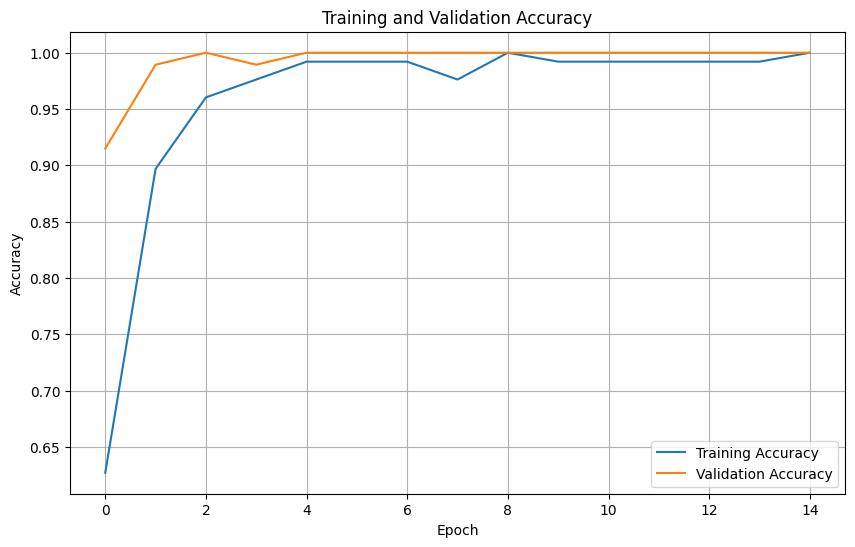

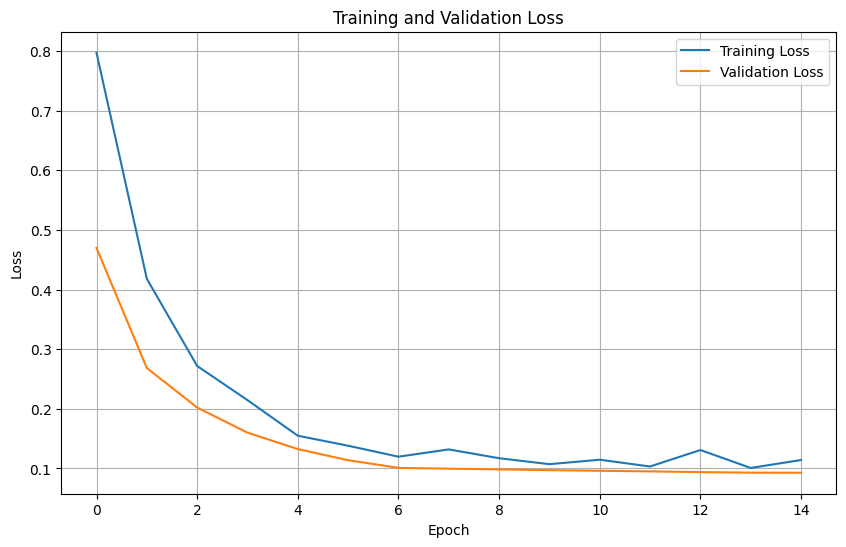

In [ ]:
pretrained_model = models.vgg16(pretrained=True)

for param in pretrained_model.parameters():
    param.requires_grad = False

#exchange the last layer
# Exchange the last layer
num_ftrs = pretrained_model.classifier[6].in_features
pretrained_model.classifier[6] = nn.Linear(num_ftrs, 3)  # Modify the last layer to have 3 output classes
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=15)